In [1]:
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

## Preprocessing Data

In [2]:
np.random.seed(100)

fundamentals = pd.read_csv('../data/stocks_data_fundamentals.csv',index_col=0, parse_dates=True)

fundamentals['dates'] = pd.to_datetime(fundamentals['dates'],format='%b %y')

stocks = fundamentals['stocks'].unique()

for stock in tqdm(stocks):
    
    df = fundamentals.loc[fundamentals['stocks'] == stock]
    df.replace(0,df.median(axis=1),inplace=True)
    fundamentals.loc[df.index, :] = df

  0%|          | 0/101 [00:00<?, ?it/s]

In [3]:
fundamentals

,stocks,dates,BasicEPS,DilutedEPS,CashEPS,DivPS,OpRev,NPS,ROCE,NPMargin,...,ROE2Networth,EntValue,EntValuePerNetSales,Price2Book,Price2Sales,RetentionRatios,EarningYield,AssetTurnRatio,EVPerEBITDA,PBDITMargin
0,SBI,2021-03-01,22.87,22.87,26.59,4.0,297.10,22.87,1.64,7.69,...,8.86,4210541.48,15.88,1.41,1.23,82.50,0.06,---,---,---
1,SBI,2020-03-01,16.23,16.23,19.94,0.0,288.33,16.23,1.79,5.63,...,6.95,3565310.84,13.86,0.84,0.68,100.00,0.08,---,---,---
2,SBI,2019-03-01,0.97,0.97,0.97,0.0,272.13,0.97,0.00,0.35,...,0.39,3423771.88,14.10,1.30,1.18,100.00,0.00,---,---,---
3,SBI,2018-03-01,-7.67,-7.67,-4.07,0.0,247.07,-7.34,1.81,-2.96,...,-3.37,3141292.12,14.25,1.15,1.01,100.00,-0.03,---,---,---
4,SBI,2017-03-01,13.43,13.43,16.02,2.6,220.13,13.15,1.99,5.97,...,6.69,2467752.16,14.06,1.49,1.33,79.88,0.04,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,ZEEL,2016-03-01,17.44,17.38,36.30,2.5,366.32,17.41,13.44,4.75,...,14.91,8347.30,3.46,10.91,3.48,85.64,0.01,65.74,29.52,35.44
999,ZEEL,2015-03-01,18.82,18.72,33.77,2.5,316.38,18.80,16.65,5.94,...,18.36,9665.77,4.66,14.45,4.67,88.95,0.01,68.17,27.69,33.24
1000,JUBLFOOD,2014-03-01,19.25,19.12,30.94,0.0,263.37,19.22,20.64,7.29,...,22.32,6957.27,4.04,12.39,4.05,100.00,0.02,61.20,27.14,37.12
1001,JUBLFOOD,2013-03-01,20.73,20.55,29.07,0.0,215.61,20.70,29.14,9.59,...,30.97,8082.55,5.74,18.61,5.77,100.00,0.02,65.20,22.97,39.53


In [4]:
fundamentals.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,BasicEPS,DilutedEPS,CashEPS,DivPS,OpRev,NPS,ROCE,NPMargin,ROA,ROE2Networth,EntValue,EntValuePerNetSales,Price2Book,Price2Sales,RetentionRatios,EarningYield
BasicEPS,1.000,0.993,0.957,0.270,0.908,0.970,0.051,-0.013,0.129,0.033,-0.032,-0.028,0.021,-0.024,0.039,0.027
DilutedEPS,0.993,1.000,0.956,0.270,0.913,0.966,0.048,-0.013,0.130,0.032,-0.034,-0.029,0.019,-0.025,0.036,0.027
CashEPS,0.957,0.956,1.000,0.261,0.963,0.987,0.049,-0.014,0.046,0.029,-0.037,-0.029,0.005,-0.025,0.050,0.023
DivPS,0.270,0.270,0.261,1.000,0.218,0.282,0.404,0.013,0.034,0.193,-0.033,-0.010,0.390,-0.001,-0.203,0.018
OpRev,0.908,0.913,0.963,0.218,1.000,0.941,0.020,-0.020,0.008,0.018,-0.040,-0.037,-0.018,-0.033,0.054,0.024
NPS,0.970,0.966,0.987,0.282,0.941,1.000,0.074,-0.013,0.067,0.045,-0.033,-0.029,0.023,-0.025,0.049,0.028
ROCE,0.051,0.048,0.049,0.404,0.020,0.074,1.000,0.296,-0.136,0.478,-0.104,0.221,0.586,0.244,-0.100,0.062
NPMargin,-0.013,-0.013,-0.014,0.013,-0.020,-0.013,0.296,1.000,0.030,0.193,0.006,0.876,0.063,0.880,-0.070,0.028
ROA,0.129,0.130,0.046,0.034,0.008,0.067,-0.136,0.030,1.000,-0.057,0.007,0.029,0.048,0.029,-0.022,0.014
ROE2Networth,0.033,0.032,0.029,0.193,0.018,0.045,0.478,0.193,-0.057,1.000,-0.027,0.141,0.320,0.147,-0.000,0.837


In [5]:
fundamentals = fundamentals[['stocks','dates','NPS','DivPS','ROCE','NPMargin','EntValue','Price2Book','RetentionRatios','EarningYield']]

fundamentals = fundamentals.sort_values(by=['stocks','dates']).reset_index(drop=True)

#fundamentals['NPS_Prcnt_change'] = fundamentals.groupby(['stocks']).NPS.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['ROCE_Prcnt_change'] = fundamentals.groupby(['stocks']).ROCE.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['NPMargin_Prcnt_change'] = fundamentals.groupby(['stocks']).NPMargin.pct_change(periods=1).apply(lambda x: x*100)
fundamentals['EntValue_Prcnt_change'] = fundamentals.groupby(['stocks']).EntValue.pct_change(periods=1).apply(lambda x: x*100)
fundamentals['Price2Book_Prcnt_change'] = fundamentals.groupby(['stocks']).Price2Book.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['RetentionRatios_Prcnt_change'] = fundamentals.groupby(['stocks']).RetentionRatios.pct_change(periods=1).apply(lambda x: x*100)
#fundamentals['EarningYield_Prcnt_change'] = fundamentals.groupby(['stocks']).EarningYield.pct_change(periods=1).apply(lambda x: x*100)

In [6]:
fundamentals = fundamentals.sort_values(by=['stocks','dates'],ascending=False).reset_index(drop=True)

from statsmodels.stats.outliers_influence import variance_inflation_factor

X = fundamentals[['NPS','DivPS','ROCE','NPMargin','EntValue','Price2Book','RetentionRatios','EarningYield']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns


vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,NPS,1.172719
1,DivPS,1.693306
2,ROCE,3.121709
3,NPMargin,1.143472
4,EntValue,1.106869
5,Price2Book,2.463876
6,RetentionRatios,1.395089
7,EarningYield,1.028868


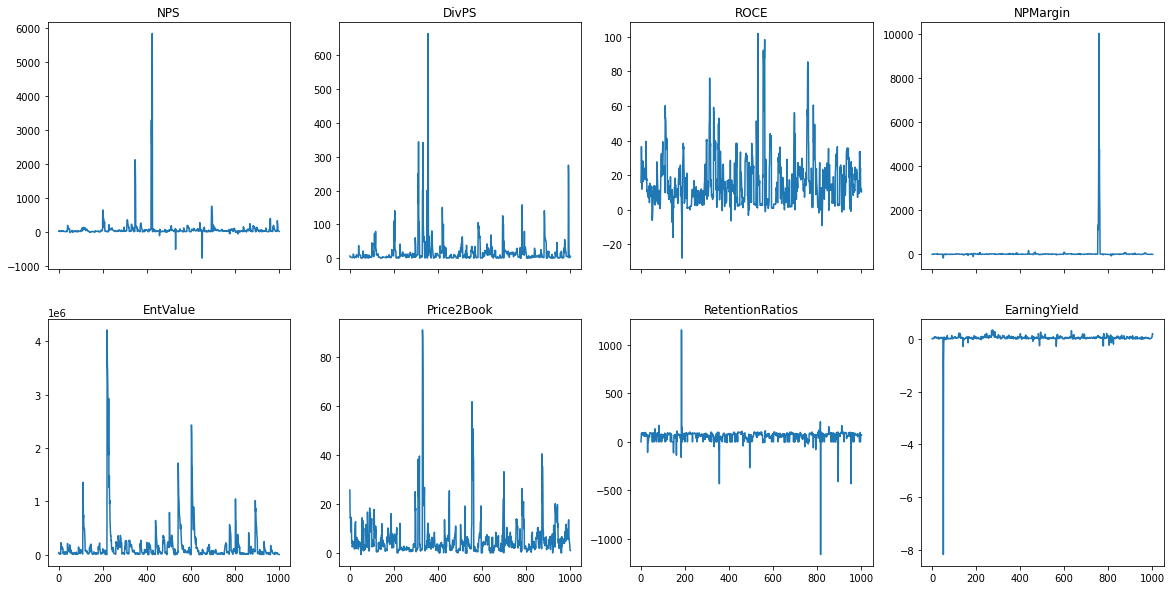

In [7]:
fig ,ax = plt.subplots(figsize = (20,10), ncols = 4, nrows = 2, sharex = True)

temp = fundamentals.drop(columns=['stocks','dates','EntValue_Prcnt_change','Price2Book_Prcnt_change'], axis=1)

columns = temp.columns

for i, column in enumerate(columns):

    if i < 4:
        ax[0][i].set_title(column)
        ax[0][i].plot(temp[column])

    if i >= 4:
        ax[1][i % 4].set_title(column)
        ax[1][i % 4].plot(temp[column])
            
plt.show()

In [8]:
def label(df):
    """
    Creates classes of:
    - buy(1)
    - sell(0)
    
    Threshold can be changed to fit whatever price change is desired
    """
    result = score(df)
    
    if result >= 4:
        return 1
    else:
        return 0

def score(df,thres=10):
    result = 0
    if df['NPS'] >= thres :
        result += 1
    if df['DivPS'] >= thres :
        result += 1
    if df['ROCE'] >= thres :
        result += 1
    if df['NPMargin'] >= thres :
        result += 1
    if df['EntValue_Prcnt_change'] >= thres :
        result += 1
    if df['Price2Book_Prcnt_change'] >= thres :
        result += 1
    if df['RetentionRatios'] >= thres :
        result += 1
    if df['EarningYield'] >= thres :
        result += 1
    return result


In [9]:
fundamentals['Label'] = 0.0
fundamentals['Score'] = 0.0

for stock in tqdm(stocks):
    # Assigning the the new DF
    new_df = fundamentals[fundamentals['stocks'] == stock]
    
    new_df['Label'] = new_df.apply(label, axis=1)#.shift(-1)
    new_df['Score'] = new_df.apply(score, axis=1)#.shift(-1)
    
    fundamentals.loc[new_df.index, :] = new_df[:]

fundamentals = fundamentals.dropna()

  0%|          | 0/101 [00:00<?, ?it/s]

In [10]:
fundamentals[fundamentals['stocks'] == 'JUBLFOOD']

,stocks,dates,NPS,DivPS,ROCE,NPMargin,EntValue,Price2Book,RetentionRatios,EarningYield,EntValue_Prcnt_change,Price2Book_Prcnt_change,Label,Score
450,JUBLFOOD,2014-03-01,19.22,0.0,20.64,7.29,6957.27,12.39,100.0,0.02,-13.922339,-33.422891,0.0,3.0
451,JUBLFOOD,2013-03-01,20.70,0.0,29.14,9.59,8082.55,18.61,100.0,0.02,6.489320,-26.674547,0.0,3.0


In [11]:
fundamentals.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,NPS,DivPS,ROCE,NPMargin,EntValue,Price2Book,RetentionRatios,EarningYield,EntValue_Prcnt_change,Price2Book_Prcnt_change,Label,Score
NPS,1.000,0.279,0.085,-0.014,-0.039,0.020,0.045,0.027,-0.008,0.002,0.142,0.167
DivPS,0.279,1.000,0.423,0.012,-0.043,0.394,-0.206,0.019,-0.000,0.103,0.247,0.296
ROCE,0.085,0.423,1.000,0.318,-0.116,0.591,-0.104,0.069,-0.054,0.018,0.425,0.508
NPMargin,-0.014,0.012,0.318,1.000,0.003,0.061,-0.068,0.029,-0.022,-0.019,0.067,0.037
EntValue,-0.039,-0.043,-0.116,0.003,1.000,-0.038,0.045,0.005,0.027,0.055,0.002,-0.015
Price2Book,0.020,0.394,0.591,0.061,-0.038,1.000,-0.075,-0.016,0.016,0.183,0.181,0.261
RetentionRatios,0.045,-0.206,-0.104,-0.068,0.045,-0.075,1.000,0.051,0.026,-0.040,0.090,0.105
EarningYield,0.027,0.019,0.069,0.029,0.005,-0.016,0.051,1.000,0.006,-0.120,0.109,0.123
EntValue_Prcnt_change,-0.008,-0.000,-0.054,-0.022,0.027,0.016,0.026,0.006,1.000,0.118,0.029,0.075
Price2Book_Prcnt_change,0.002,0.103,0.018,-0.019,0.055,0.183,-0.040,-0.120,0.118,1.000,0.123,0.227


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = fundamentals.drop(columns=['Label','Score','stocks','dates','EntValue'], axis=1)
X = X.replace((np.inf, -np.inf, np.nan), 0)
y = fundamentals.Label

scaler = StandardScaler()

scaler.fit_transform(X)

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=50,shuffle=True,train_size=0.8)

pre_optimization_precision = []
post_optimization_precision = []
pre_optimization_accuracy = []
post_optimization_accuracy = []

In [13]:
# Importing the model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Fitting and training
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [14]:
# Classifier predictions
AdaBoost_pred = AdaBoost_clf.predict(X_test)

#Printing out results
AdaBoost_report = classification_report(y_test, AdaBoost_pred)
print(AdaBoost_report)

pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=AdaBoost_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=AdaBoost_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        54
         1.0       0.99      0.98      0.99       121

    accuracy                           0.98       175
   macro avg       0.98      0.98      0.98       175
weighted avg       0.98      0.98      0.98       175



In [15]:
# Parameters to Tune
params = {'n_estimators': [50, 100, 200, 500, 600 , 700],
          'learning_rate': [1, .1, .01]}

AdaBoost_search = GridSearchCV(AdaBoost_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

AdaBoost_search.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=1, n_estimators=50;, score=(train=0.996, test=0.983) total time=   0.1s
[CV 2/5] END learning_rate=1, n_estimators=50;, score=(train=0.999, test=0.977) total time=   0.1s
[CV 3/5] END learning_rate=1, n_estimators=50;, score=(train=0.997, test=0.971) total time=   0.1s
[CV 4/5] END learning_rate=1, n_estimators=50;, score=(train=0.996, test=0.960) total time=   0.1s
[CV 5/5] END learning_rate=1, n_estimators=50;, score=(train=0.996, test=0.960) total time=   0.1s
[CV 1/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.977) total time=   0.3s
[CV 2/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.977) total time=   0.3s
[CV 3/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.971) total time=   0.3s
[CV 4/5] END learning_rate=1, n_estimators=100;, score=(train=1.000, test=0.954) total time=   0.3s
[CV 5/5] END learning_rate=1, n_estimators=1

[CV 2/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.950, test=0.966) total time=   2.2s
[CV 3/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.941, test=0.903) total time=   2.4s
[CV 4/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.959, test=0.926) total time=   2.4s
[CV 5/5] END learning_rate=0.01, n_estimators=600;, score=(train=0.947, test=0.925) total time=   2.3s
[CV 1/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.951, test=0.937) total time=   2.8s
[CV 2/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.956, test=0.971) total time=   2.7s
[CV 3/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.947, test=0.937) total time=   2.8s
[CV 4/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.963, test=0.926) total time=   2.7s
[CV 5/5] END learning_rate=0.01, n_estimators=700;, score=(train=0.960, test=0.954) total time=   2.7s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [50, 100, 200, 500, 600, 700]},
             return_train_score=True, scoring='accuracy', verbose=5)

In [16]:
print("Best Accuracy: %f using %s" % (AdaBoost_search.best_score_, AdaBoost_search.best_params_))
print("Mean Training Score:", np.mean(AdaBoost_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", AdaBoost_search.score(X, y))
print("\nBest Parameter Found:")
AdaBoost_search.best_params_

Best Accuracy: 0.988558 using {'learning_rate': 1, 'n_estimators': 700}
Mean Training Score: 0.9626083747757568
Mean Testing Score: 1.0

Best Parameter Found:


{'learning_rate': 1, 'n_estimators': 700}

In [17]:
AdaBoost_search = AdaBoost_search.best_estimator_

AdaBoost_search.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=700)

In [18]:
# Classifier predictions
AdaBoost_pred = AdaBoost_search.predict(X_test)

#Printing out results
AdaBoost_report = classification_report(y_test, AdaBoost_pred)
print(AdaBoost_report)

post_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=AdaBoost_pred),3))
post_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=AdaBoost_pred),3))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        54
         1.0       1.00      0.98      0.99       121

    accuracy                           0.99       175
   macro avg       0.98      0.99      0.99       175
weighted avg       0.99      0.99      0.99       175



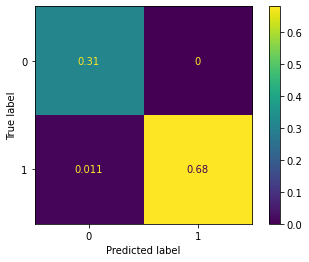

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

AdaBoost_cm = confusion_matrix(y_test, AdaBoost_pred, normalize='all')
AdaBoost_cmd = ConfusionMatrixDisplay(AdaBoost_cm)
AdaBoost_cmd.plot()

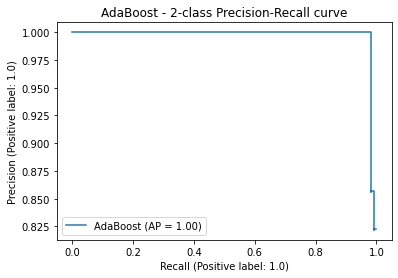

In [20]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    AdaBoost_search, X_test, y_test, name="AdaBoost"
)
_ = display.ax_.set_title("AdaBoost - 2-class Precision-Recall curve")

In [21]:
# Importing the model
from sklearn.naive_bayes import GaussianNB

# Fitting and training
NB_clf = GaussianNB()
NB_clf.fit(X_train, y_train)

GaussianNB()

In [22]:
# Classifier predictions
NB_pred = NB_clf.predict(X_test)

#Printing out results
NB_report = classification_report(y_test, NB_pred)
print(NB_report)
pre_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=NB_pred),3))
pre_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=NB_pred),3))

              precision    recall  f1-score   support

         0.0       0.46      0.98      0.63        54
         1.0       0.98      0.50      0.66       121

    accuracy                           0.65       175
   macro avg       0.72      0.74      0.65       175
weighted avg       0.82      0.65      0.65       175



In [23]:
# Parameters to Tune
params = {'var_smoothing': [i for i in np.arange(-10, 10, 0.1)]}

NB_search = GridSearchCV(NB_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

NB_search.fit(X,y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END var_smoothing=-10.0;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-10.0;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-10.0;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-10.0;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-10.0;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-9.9;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-9.9;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-9.9;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-9.9;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-9.9;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-9.8;, score=(train=0.325, test=0.326) total time=   0

[CV 2/5] END var_smoothing=-8.300000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-8.300000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-8.300000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-8.300000000000006;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-8.200000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-8.200000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-8.200000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-8.200000000000006;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-8.200000000000006;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-8.100000000000007;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] E

[CV 2/5] END var_smoothing=-6.600000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-6.600000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-6.600000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-6.600000000000012;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-6.500000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-6.500000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-6.500000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-6.500000000000012;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-6.500000000000012;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-6.400000000000013;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] E

[CV 5/5] END var_smoothing=-5.000000000000018;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-4.900000000000018;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-4.900000000000018;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-4.900000000000018;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-4.900000000000018;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-4.900000000000018;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-4.8000000000000185;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-4.8000000000000185;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-4.8000000000000185;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-4.8000000000000185;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/

[CV 4/5] END var_smoothing=-3.200000000000024;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-3.200000000000024;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-3.1000000000000245;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-3.1000000000000245;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-3.1000000000000245;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-3.1000000000000245;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-3.1000000000000245;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-3.000000000000025;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-3.000000000000025;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-3.000000000000025;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4

[CV 2/5] END var_smoothing=-1.300000000000031;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-1.300000000000031;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-1.300000000000031;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-1.300000000000031;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-1.2000000000000313;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 2/5] END var_smoothing=-1.2000000000000313;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 3/5] END var_smoothing=-1.2000000000000313;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 4/5] END var_smoothing=-1.2000000000000313;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 5/5] END var_smoothing=-1.2000000000000313;, score=(train=0.326, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=-1.1000000000000316;, score=(train=0.325, test=0.326) total time=   0.0s
[CV 

[CV 2/5] END var_smoothing=0.4999999999999627;, score=(train=0.369, test=0.423) total time=   0.0s
[CV 3/5] END var_smoothing=0.4999999999999627;, score=(train=0.677, test=0.680) total time=   0.0s
[CV 4/5] END var_smoothing=0.4999999999999627;, score=(train=0.678, test=0.657) total time=   0.0s
[CV 5/5] END var_smoothing=0.4999999999999627;, score=(train=0.366, test=0.322) total time=   0.0s
[CV 1/5] END var_smoothing=0.5999999999999623;, score=(train=0.382, test=0.371) total time=   0.0s
[CV 2/5] END var_smoothing=0.5999999999999623;, score=(train=0.408, test=0.480) total time=   0.0s
[CV 3/5] END var_smoothing=0.5999999999999623;, score=(train=0.678, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=0.5999999999999623;, score=(train=0.680, test=0.669) total time=   0.0s
[CV 5/5] END var_smoothing=0.5999999999999623;, score=(train=0.367, test=0.328) total time=   0.0s
[CV 1/5] END var_smoothing=0.699999999999962;, score=(train=0.429, test=0.406) total time=   0.0s
[CV 2/5] EN

[CV 2/5] END var_smoothing=2.1999999999999567;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=2.1999999999999567;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=2.1999999999999567;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=2.1999999999999567;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=2.2999999999999563;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=2.2999999999999563;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=2.2999999999999563;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=2.2999999999999563;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=2.2999999999999563;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=2.399999999999956;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 2/5] EN

[CV 4/5] END var_smoothing=3.9999999999999503;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=3.9999999999999503;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=4.09999999999995;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=4.09999999999995;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=4.09999999999995;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=4.09999999999995;, score=(train=0.677, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=4.09999999999995;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=4.1999999999999496;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=4.1999999999999496;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=4.1999999999999496;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smo

[CV 5/5] END var_smoothing=5.799999999999944;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=5.8999999999999435;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=5.8999999999999435;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=5.8999999999999435;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=5.8999999999999435;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=5.8999999999999435;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=5.999999999999943;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=5.999999999999943;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=5.999999999999943;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=5.999999999999943;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END va

[CV 1/5] END var_smoothing=7.5999999999999375;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=7.5999999999999375;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=7.5999999999999375;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=7.5999999999999375;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=7.5999999999999375;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=7.699999999999939;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=7.699999999999939;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=7.699999999999939;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=7.699999999999939;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=7.699999999999939;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END va

[CV 2/5] END var_smoothing=9.499999999999929;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=9.499999999999929;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=9.499999999999929;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=9.499999999999929;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=9.59999999999993;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothing=9.59999999999993;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END var_smoothing=9.59999999999993;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END var_smoothing=9.59999999999993;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END var_smoothing=9.59999999999993;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END var_smoothing=9.699999999999932;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END var_smoothin

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [-10.0, -9.9, -9.8,
                                           -9.700000000000001,
                                           -9.600000000000001,
                                           -9.500000000000002,
                                           -9.400000000000002,
                                           -9.300000000000002,
                                           -9.200000000000003,
                                           -9.100000000000003,
                                           -9.000000000000004,
                                           -8.900000000000004,
                                           -8.800000000000004,
                                           -8.700000000000005,
                                           -8.600000000000005,
                                           -8.500000000000005,
                                           -8.400000000000006,
             

In [24]:
print("Best Accuracy: %f using %s" % (NB_search.best_score_, NB_search.best_params_))
print("Mean Test Score:", np.mean(NB_search.cv_results_['mean_test_score']))
print("Mean Std. Test Score:", np.mean(NB_search.cv_results_['std_test_score']))
print("\nBest Parameter Found:")
NB_search.best_params_

Best Accuracy: 0.679665 using {'var_smoothing': 0.9999999999999609}
Mean Test Score: 0.4925649917898194
Mean Std. Test Score: 0.008472236596481848

Best Parameter Found:


{'var_smoothing': 0.9999999999999609}

In [25]:
NB_search = NB_search.best_estimator_

NB_search.fit(X_train, y_train)

GaussianNB(var_smoothing=0.9999999999999609)

In [26]:
# Classifier predictions
NB_pred = NB_search.predict(X_test)

#Printing out results
NB_report = classification_report(y_test, NB_pred)
print(NB_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=NB_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=NB_pred))

              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50        54
         1.0       1.00      0.09      0.17       121

    accuracy                           0.37       175
   macro avg       0.66      0.55      0.33       175
weighted avg       0.79      0.37      0.27       175



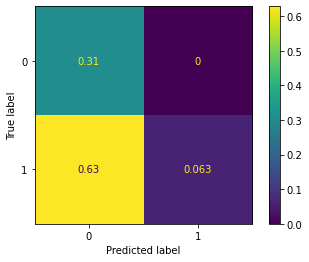

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
NB_cm = confusion_matrix(y_test, NB_pred, normalize='all')
NB_cmd = ConfusionMatrixDisplay(NB_cm)
NB_cmd.plot()

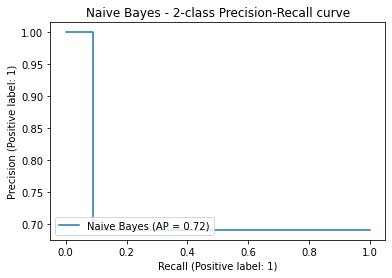

In [28]:
display = PrecisionRecallDisplay.from_predictions(y_test, NB_pred, name="Naive Bayes")
_ = display.ax_.set_title("Naive Bayes - 2-class Precision-Recall curve")

In [29]:
# Importing the model
from sklearn.linear_model import LogisticRegression

# Fitting and training
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Classifier predictions
LogReg_pred = LogReg_clf.predict(X_test)

#Printing out results
LogReg_report = classification_report(y_test, LogReg_pred)
print(LogReg_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=LogReg_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=LogReg_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75        54
         1.0       0.89      0.88      0.89       121

    accuracy                           0.85       175
   macro avg       0.82      0.82      0.82       175
weighted avg       0.85      0.85      0.85       175



In [31]:
# Parameters to Tune
params = {'penalty': ['l1', 'l2'],
          'C': [n for n in range(1, 10, 1)],
          'intercept_scaling': [0.01, 0.1, 1, 10, 50, 100],
          'solver': ['liblinear', 'saga','newton-cg', 'lbfgs']}

LogReg_search = GridSearchCV(LogReg_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

LogReg_search.fit(X,y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.750, test=0.766) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.741, test=0.760) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.781, test=0.697) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.754, test=0.771) total time=   0.0s
[CV 5/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=liblinear;, score=(train=0.796, test=0.764) total time=   0.0s
[CV 1/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.715, test=0.714) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=0.01, penalty=l1, solver=saga;, score=(tra

[CV 2/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.876, test=0.800) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.858, test=0.903) total time=   0.0s
[CV 5/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.891) total time=   0.0s
[CV 1/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.867, test=0.874) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.871, test=0.800) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.856, test=0.909) total time=   0.0s
[CV 5/5] END C=1, intercept_scal

[CV 3/5] END C=1, intercept_scaling=10, penalty=l2, solver=liblinear;, score=(train=0.873, test=0.800) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=10, penalty=l2, solver=liblinear;, score=(train=0.858, test=0.903) total time=   0.0s
[CV 5/5] END C=1, intercept_scaling=10, penalty=l2, solver=liblinear;, score=(train=0.863, test=0.891) total time=   0.0s
[CV 1/5] END C=1, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.715, test=0.714) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=1, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=1, intercept_scaling=10, penalty=l

[CV 1/5] END C=1, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.715, test=0.714) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=1, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=1, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.863) total time=   0.0s
[CV 2/5] END C=1, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=1, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.876, test=0.800) total time=   0.0s
[CV 4/5] END C=1, intercept_scaling=100, 

[CV 4/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.877, test=0.800) total time=   0.0s
[CV 4/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.903) total time=   0.0s
[CV 5/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.891) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.870, test=0.869) total time=   0.0s
[CV 2/5] END C=2, intercept_sc

[CV 5/5] END C=2, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.741) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=2, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=2, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.877, test=0.800) total time=   0.0s
[CV 4/5] END C=2, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.903) total time=   0.0s
[CV 5/5] END C=2, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.891) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.870, test=0.869) total time=   0.0s
[CV 2/5] END C=2, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=2, intercept_scaling=1

[CV 4/5] END C=2, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=2, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=2, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=2, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.877, test=0.800) total time=   0.0s
[CV 4/5] END C=2, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.903) total time=   0.0s
[CV 5/5] END C=2, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.863, test=0.891) total time=   0.0s
[CV 1/5] END C=2, intercept_scaling=100, penalty=l2, solver=lbfgs;, score=(train=0.870, test=0.869) total time=   0.0s
[CV 2/5] END C=2, intercept_sc

[CV 3/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.878, test=0.794) total time=   0.0s
[CV 4/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.897) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=3, intercept_sca

[CV 4/5] END C=3, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=3, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=3, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=3, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.878, test=0.794) total time=   0.0s
[CV 4/5] END C=3, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.897) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=3, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.870, test=0.869) total time=   0.0s
[CV 2/5] END C=3, intercept_scaling=10

[CV 3/5] END C=3, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=3, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=3, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=3, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=3, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.878, test=0.794) total time=   0.0s
[CV 4/5] END C=3, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.897) total time=   0.0s
[CV 5/5] END C=3, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=3, intercept_sca

[CV 3/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.880, test=0.794) total time=   0.0s
[CV 4/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=4, intercept_sca

[CV 4/5] END C=4, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=4, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=4, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=4, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.880, test=0.794) total time=   0.0s
[CV 4/5] END C=4, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=4, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=4, intercept_scaling=10

[CV 3/5] END C=4, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=4, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=4, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=4, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=4, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.880, test=0.794) total time=   0.0s
[CV 4/5] END C=4, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=4, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=4, intercept_sca

[CV 5/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=5, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=5, intercept_s

[CV 5/5] END C=5, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=5, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=5, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=5, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=5, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=5, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=5, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=5, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=5, intercept_scaling=1

[CV 3/5] END C=5, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=5, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=5, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=5, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.870, test=0.863) total time=   0.0s
[CV 2/5] END C=5, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=5, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=5, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.897) total time=   0.0s
[CV 5/5] END C=5, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.885) total time=   0.0s
[CV 1/5] END C=5, intercept_sca

[CV 3/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.903) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.891) total time=   0.0s
[CV 1/5] END C=6, intercept_sca

[CV 4/5] END C=6, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=6, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=6, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=6, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=6, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.903) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.891) total time=   0.0s
[CV 1/5] END C=6, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=6, intercept_scaling=10

[CV 4/5] END C=6, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=6, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=6, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=6, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=6, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.903) total time=   0.0s
[CV 5/5] END C=6, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.891) total time=   0.0s
[CV 1/5] END C=6, intercept_scaling=100, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=6, intercept_sc

[CV 1/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.715, test=0.714) total time=   0.0s
[CV 2/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.1s
[CV 2/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=7, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=7, intercept_scaling=0.1, 

[CV 4/5] END C=7, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=7, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=7, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=7, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=7, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=7, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=7, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.891) total time=   0.0s
[CV 1/5] END C=7, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.867, test=0.863) total time=   0.0s
[CV 2/5] END C=7, intercept_scaling=10

[CV 4/5] END C=7, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=7, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=7, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=7, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=7, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=7, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=7, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.860, test=0.891) total time=   0.0s
[CV 1/5] END C=7, intercept_scaling=100, penalty=l2, solver=lbfgs;, score=(train=0.867, test=0.863) total time=   0.0s
[CV 2/5] END C=7, intercept_sc

[CV 5/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.891) total time=   0.0s
[CV 1/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=8, intercept_scaling=0.1, penalty=l2, solver=lbfgs;, score=(train=0.863, test=0.846) total time=   0.0s
[CV 3/5] END C=8, intercept_s

[CV 2/5] END C=8, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=8, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=8, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=8, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=8, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=8, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=8, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=8, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=8, intercept_scaling=10, pena

[CV 4/5] END C=8, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=8, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=8, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.871, test=0.869) total time=   0.0s
[CV 2/5] END C=8, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=8, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=8, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=8, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.891) total time=   0.0s
[CV 1/5] END C=8, intercept_scaling=100, penalty=l2, solver=lbfgs;, score=(train=0.868, test=0.869) total time=   0.0s
[CV 2/5] END C=8, intercept_sc

[CV 3/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.873, test=0.869) total time=   0.0s
[CV 2/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.867, test=0.903) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=0.1, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.891) total time=   0.0s
[CV 1/5] END C=9, intercept_sca

[CV 4/5] END C=9, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=10, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=9, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.873, test=0.869) total time=   0.0s
[CV 2/5] END C=9, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.864, test=0.846) total time=   0.0s
[CV 3/5] END C=9, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.883, test=0.794) total time=   0.0s
[CV 4/5] END C=9, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.867, test=0.903) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=10, penalty=l2, solver=newton-cg;, score=(train=0.861, test=0.891) total time=   0.0s
[CV 1/5] END C=9, intercept_scaling=10, penalty=l2, solver=lbfgs;, score=(train=0.861, test=0.874) total time=   0.0s
[CV 2/5] END C=9, intercept_scaling=10

[CV 4/5] END C=9, intercept_scaling=100, penalty=l2, solver=liblinear;, score=(train=0.866, test=0.903) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=100, penalty=l2, solver=liblinear;, score=(train=0.861, test=0.885) total time=   0.0s
[CV 1/5] END C=9, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.714, test=0.714) total time=   0.0s
[CV 2/5] END C=9, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.712, test=0.703) total time=   0.0s
[CV 3/5] END C=9, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.720) total time=   0.0s
[CV 4/5] END C=9, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.741, test=0.726) total time=   0.0s
[CV 5/5] END C=9, intercept_scaling=100, penalty=l2, solver=saga;, score=(train=0.717, test=0.736) total time=   0.0s
[CV 1/5] END C=9, intercept_scaling=100, penalty=l2, solver=newton-cg;, score=(train=0.873, test=0.869) total time=   0.1s
[CV 2/5] END C=9, intercept_scaling=100, 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'intercept_scaling': [0.01, 0.1, 1, 10, 50, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [32]:
print("Best Accuracy: %f using %s" % (LogReg_search.best_score_, LogReg_search.best_params_))
print("Mean Training Score:", np.mean(LogReg_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", LogReg_search.score(X, y))
print("\nBest Parameter Found:")
LogReg_search.best_params_

Best Accuracy: 0.862739 using {'C': 6, 'intercept_scaling': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Mean Training Score: nan
Mean Testing Score: 0.8672768878718535

Best Parameter Found:


{'C': 6, 'intercept_scaling': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [33]:
LogReg_search = LogReg_search.best_estimator_

LogReg_search.fit(X_train, y_train)

LogisticRegression(C=6, intercept_scaling=0.1, penalty='l1', solver='liblinear')

In [34]:
# Classifier predictions
LogReg_pred = LogReg_search.predict(X_test)

#Printing out results
LogReg_report = classification_report(y_test, LogReg_pred)
print(LogReg_report)
post_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=LogReg_pred),3))
post_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=LogReg_pred),3))

              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77        54
         1.0       0.89      0.90      0.90       121

    accuracy                           0.86       175
   macro avg       0.83      0.83      0.83       175
weighted avg       0.86      0.86      0.86       175



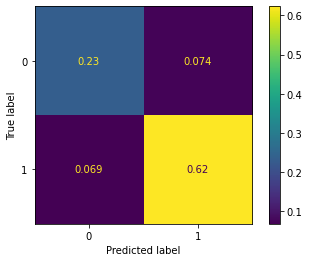

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

LogReg_cm = confusion_matrix(y_test, LogReg_pred, normalize='all')
LogReg_cmd = ConfusionMatrixDisplay(LogReg_cm)
LogReg_cmd.plot()

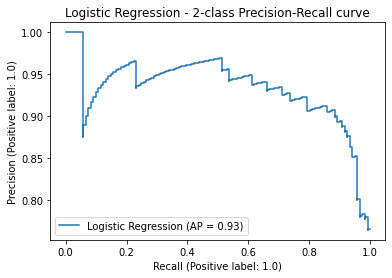

In [36]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    LogReg_search, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("Logistic Regression - 2-class Precision-Recall curve")

In [37]:
# Importing the model
from sklearn.svm import SVC

# Fitting and training
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [38]:
# Classifier predictions
svm_pred = svm_clf.predict(X_test)

#Printing out results
svm_report = classification_report(y_test, svm_pred)
print(svm_report)
pre_optimization_precision.append(precision_score(y_true=y_test, y_pred=svm_pred))
pre_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=svm_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.33      0.49        54
         1.0       0.77      0.98      0.86       121

    accuracy                           0.78       175
   macro avg       0.83      0.66      0.67       175
weighted avg       0.81      0.78      0.75       175



In [39]:
# Parameters to Tune
params = {"C": [.0001, .001,.01,0.1,1,2,5],
          "kernel":['rbf','sigmoid','linear'],
         'gamma': [0.001, 0.0001],}

svm_search = GridSearchCV(svm_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

svm_search.fit(X,y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.001, kernel=rbf;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END C=0.0001,

[CV 2/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.880, test=0.874) total time=   0.0s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.874, test=0.840) total time=   0.2s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.874, test=0.800) total time=   0.1s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.868, test=0.897) total time=   0.0s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=linear;, score=(train=0.871, test=0.874) total time=   0.0s
[CV 1/5] END C=0.1, gamma=0.001, kernel=rbf;, score=(train=0.765, test=0.754) 

[CV 5/5] END C=2, gamma=0.001, kernel=linear;, score=(train=0.874, test=0.897) total time=   6.9s
[CV 1/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.931, test=0.863) total time=   0.0s
[CV 2/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.917, test=0.903) total time=   0.0s
[CV 3/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.918, test=0.851) total time=   0.0s
[CV 4/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.921, test=0.886) total time=   0.0s
[CV 5/5] END C=2, gamma=0.0001, kernel=rbf;, score=(train=0.917, test=0.856) total time=   0.0s
[CV 1/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.671, test=0.617) total time=   0.0s
[CV 2/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.662, test=0.686) total time=   0.0s
[CV 3/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.697, test=0.634) total time=   0.0s
[CV 4/5] END C=2, gamma=0.0001, kernel=sigmoid;, score=(train=0.662, test=0.674) total time=   0.0s
[CV 5/5] END C=2, gamm

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5],
                         'gamma': [0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [40]:
print("Best Accuracy: %f using %s" % (svm_search.best_score_, svm_search.best_params_))
print("Mean Training Score:", np.mean(svm_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", svm_search.score(X, y))
print("\nBest Parameter Found:")
svm_search.best_params_

Best Accuracy: 0.871875 using {'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}
Mean Training Score: 0.7743345693069789
Mean Testing Score: 0.8832951945080092

Best Parameter Found:


{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}

In [41]:
svm_search = svm_search.best_estimator_

svm_search.fit(X_train, y_train)

SVC(C=0.0001, gamma=0.001, kernel='linear')

In [42]:
# Classifier predictions
svm_pred = svm_search.predict(X_test)

#Printing out results
svm_report = classification_report(y_test, svm_pred)
print(svm_report)
post_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=svm_pred),3))
post_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=svm_pred),3))

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76        54
         1.0       0.88      0.93      0.90       121

    accuracy                           0.86       175
   macro avg       0.85      0.82      0.83       175
weighted avg       0.86      0.86      0.86       175



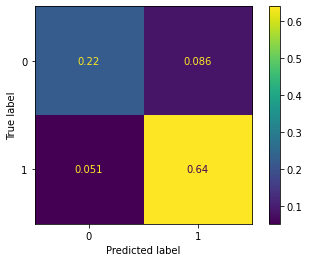

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

svm_cm = confusion_matrix(y_test, svm_pred, normalize='all')
svm_cmd = ConfusionMatrixDisplay(svm_cm)
svm_cmd.plot()

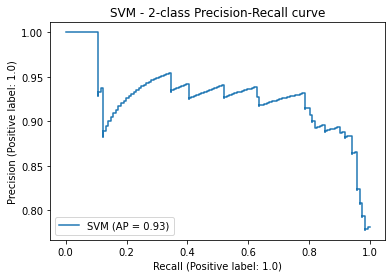

In [44]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    svm_search, X_test, y_test, name="SVM"
)
_ = display.ax_.set_title("SVM - 2-class Precision-Recall curve")

In [45]:
# Importing the model
from sklearn.neighbors import KNeighborsClassifier

# Fitting and training
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [46]:
# Classifier predictions
KNN_pred = KNN_clf.predict(X_test)

#Printing out results
KNN_report = classification_report(y_test, KNN_pred)
print(KNN_report)
pre_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=KNN_pred),3))
pre_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=KNN_pred),3))

              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69        54
         1.0       0.85      0.88      0.87       121

    accuracy                           0.81       175
   macro avg       0.78      0.77      0.78       175
weighted avg       0.81      0.81      0.81       175



In [47]:
# Parameters to Tune
params = {"n_neighbors": [10, 20, 50, 200, 400, 600],
          "weights": ['uniform', 'distance'],
          "p": [1,2]}

KNN_search = GridSearchCV(KNN_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

KNN_search.fit(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.916, test=0.886) total time=   0.0s
[CV 2/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.920, test=0.897) total time=   0.0s
[CV 3/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.916, test=0.914) total time=   0.0s
[CV 4/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.913, test=0.806) total time=   0.0s
[CV 5/5] END n_neighbors=10, p=1, weights=uniform;, score=(train=0.926, test=0.851) total time=   0.0s
[CV 1/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.886) total time=   0.0s
[CV 2/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.874) total time=   0.0s
[CV 3/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.903) total time=   0.0s
[CV 4/5] END n_neighbors=10, p=1, weights=distance;, score=(train=1.000, test=0.823) total time=   0.0s
[CV 5/5

[CV 5/5] END n_neighbors=200, p=2, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 1/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 2/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 3/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 4/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=0.675, test=0.674) total time=   0.0s
[CV 5/5] END n_neighbors=400, p=1, weights=uniform;, score=(train=0.674, test=0.678) total time=   0.0s
[CV 1/5] END n_neighbors=400, p=1, weights=distance;, score=(train=1.000, test=0.777) total time=   0.0s
[CV 2/5] END n_neighbors=400, p=1, weights=distance;, score=(train=1.000, test=0.731) total time=   0.0s
[CV 3/5] END n_neighbors=400, p=1, weights=distance;, score=(train=1.000, test=0.726) total time=   0.0s
[CV 4/5] END n_neighbors=400, p=1, weights=distance;, score=

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 20, 50, 200, 400, 600],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [48]:
print("Best Accuracy: %f using %s" % (KNN_search.best_score_, KNN_search.best_params_))
print("Mean Training Score:", np.mean(KNN_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", KNN_search.score(X, y))
print("\nBest Parameter Found:")
KNN_search.best_params_

Best Accuracy: 0.883310 using {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Mean Training Score: 0.9004813509094625
Mean Testing Score: 0.9016018306636155

Best Parameter Found:


{'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}

In [49]:
# Classifier predictions
KNN_pred = KNN_search.predict(X_test)

#Printing out results
KNN_report = classification_report(y_test, KNN_pred)
print(KNN_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=KNN_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=KNN_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        54
         1.0       0.91      0.91      0.91       121

    accuracy                           0.87       175
   macro avg       0.85      0.85      0.85       175
weighted avg       0.87      0.87      0.87       175



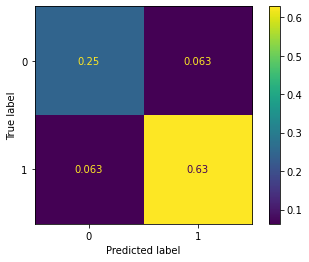

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

KNN_cm = confusion_matrix(y_test, KNN_pred, normalize='all')
KNN_cmd = ConfusionMatrixDisplay(KNN_cm)
KNN_cmd.plot()

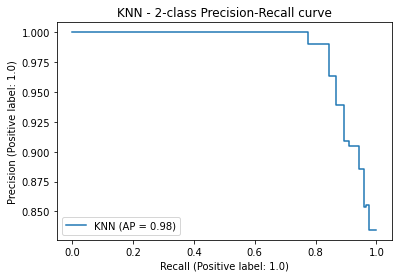

In [51]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    KNN_search, X_test, y_test, name="KNN"
)
_ = display.ax_.set_title("KNN - 2-class Precision-Recall curve")

In [52]:
# Importing the model
from sklearn.ensemble import RandomForestClassifier

# Fitting and training
RFC_clf = RandomForestClassifier()
RFC_clf.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
# Classifier predictions
RFC_pred = RFC_clf.predict(X_test)

#Printing out results
RFC_report = classification_report(y_test, RFC_pred)
print(RFC_report)
pre_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=RFC_pred),3))
pre_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=RFC_pred),3))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89        54
         1.0       0.96      0.94      0.95       121

    accuracy                           0.93       175
   macro avg       0.92      0.92      0.92       175
weighted avg       0.93      0.93      0.93       175



In [54]:
# Parameters to Tune
params = {'n_estimators': [10,25,50,100,200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 2, 5, 10],
          'min_samples_split': [5,10],
          'min_samples_leaf': [1, 2, 5]}

RFC_search = GridSearchCV(RFC_clf, params, cv=5, return_train_score=True, verbose=5, scoring='accuracy')

RFC_search.fit(X,y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.994, test=0.903) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.990, test=0.909) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.949) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.991, test=0.943) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.999, test=0.954) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=(train=0.997, test=0.909) total time=   0.0s
[CV 2/

[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.996, test=0.943) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.996, test=0.937) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.999, test=0.914) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.999, test=0.931) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.999, test=0.949) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.997, test=0.925) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_s

[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.974, test=0.937) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.980, test=0.902) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.980, test=0.926) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.981, test=0.954) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.983, test=0.943) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.980, test=0.931) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=5, min_s

[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.871, test=0.880) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.884, test=0.817) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.883, test=0.891) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.884, test=0.874) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.876, test=0.869) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.863, test=0.851) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_e

[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.876, test=0.863) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.873, test=0.886) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.881, test=0.806) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.888, test=0.874) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.871, test=0.851) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.890, test=0.863) total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5,

[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.873, test=0.868) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.880, test=0.874) total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.863, test=0.869) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.880, test=0.817) total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.888, test=0.886) total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.871, test=0.851) total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=10

[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.980, test=0.937) total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.986, test=0.908) total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.953, test=0.886) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.964, test=0.920) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.973, test=0.914) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.957, test=0.897) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10

[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.976, test=0.920) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.974, test=0.949) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.977, test=0.909) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.977, test=0.937) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.970, test=0.914) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.971, test=0.897) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=10

[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.969, test=0.914) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.976, test=0.954) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.974, test=0.914) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.973, test=0.937) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.971, test=0.914) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.974, test=0.926) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=1

[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.991, test=0.914) total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.954) total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.931) total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.966) total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.991, test=0.931) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.914) total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=1, min_sam

[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.991, test=0.931) total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.991, test=0.914) total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.991, test=0.943) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.994, test=0.920) total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.991, test=0.949) total time=   0.6s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.990, test=0.937) total time=   0.6s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_sam

[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.984, test=0.937) total time=   0.8s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=(train=0.986, test=0.937) total time=   0.8s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.991, test=0.931) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.989, test=0.931) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.993, test=0.937) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.994, test=0.954) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_sample

[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.993, test=0.914) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.996, test=0.960) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.993, test=0.943) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.996, test=0.931) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.997, test=0.943) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=(train=0.994, test=0.943) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_

[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.983, test=0.931) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.976, test=0.926) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.993, test=0.931) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.983, test=0.937) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=(train=0.989, test=0.925) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=(train=0.983, test=0.931) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=None, min_

[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=(train=0.883, test=0.874) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.883, test=0.880) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.868, test=0.880) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.881, test=0.817) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.888, test=0.886) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.884, test=0.874) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_s

[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.880, test=0.829) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.873, test=0.874) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=(train=0.866, test=0.851) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.886, test=0.869) total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.866, test=0.869) total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.876, test=0.817) total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=2, mi

[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.896, test=0.869) total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.870, test=0.874) total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.883, test=0.817) total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.890, test=0.886) total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=(train=0.884, test=0.856) total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.890, test=0.874) total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=2, min_samples_leaf=5,

[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.984, test=0.931) total time=   0.3s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=(train=0.987, test=0.943) total time=   0.3s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.983, test=0.914) total time=   0.7s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.981, test=0.954) total time=   0.7s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.990, test=0.914) total time=   0.7s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.989, test=0.926) total time=   0.7s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=1,

[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.983, test=0.954) total time=   0.6s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.984, test=0.926) total time=   0.7s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.979, test=0.943) total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.987, test=0.948) total time=   0.6s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=(train=0.969, test=0.903) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=(train=0.976, test=0.914) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2,

[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=(train=0.980, test=0.937) total time=   0.6s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.961, test=0.926) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.966, test=0.949) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.976, test=0.914) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.969, test=0.937) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=(train=0.974, test=0.931) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=5,

[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.993, test=0.926) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=(train=0.986, test=0.914) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.993, test=0.920) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.993, test=0.966) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.991, test=0.914) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=(train=0.993, test=0.943) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_

[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.994, test=0.931) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.993, test=0.931) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.991, test=0.960) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=25;, score=(train=0.989, test=0.943) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.990, test=0.926) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.993, test=0.943) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_

[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.990, test=0.920) total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.984, test=0.949) total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.991, test=0.943) total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.983, test=0.943) total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=(train=0.983, test=0.966) total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=(train=0.981, test=0.926) total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 25, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=5)

In [55]:
print("Best Accuracy: %f using %s" % (RFC_search.best_score_, RFC_search.best_params_))
print("Mean Training Score:", np.mean(RFC_search.cv_results_['mean_train_score']))
print("Mean Testing Score:", RFC_search.score(X, y))
print("\nBest Parameter Found:")
RFC_search.best_params_

Best Accuracy: 0.947356 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Mean Training Score: 0.9591189914163091
Mean Testing Score: 0.982837528604119

Best Parameter Found:


{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 10}

In [56]:
RFC_search = RFC_search.best_estimator_

RFC_search.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=10)

In [57]:
# Classifier predictions
RFC_pred = RFC_search.predict(X_test)

#Printing out results
RFC_report = classification_report(y_test, RFC_pred)
print(RFC_report)
post_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=RFC_pred),3))
post_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=RFC_pred),3))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87        54
         1.0       0.95      0.93      0.94       121

    accuracy                           0.92       175
   macro avg       0.90      0.91      0.91       175
weighted avg       0.92      0.92      0.92       175



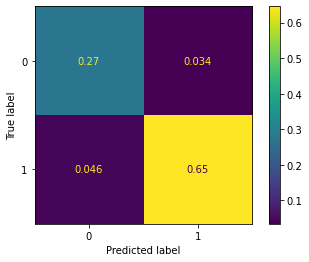

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

RFC_cm = confusion_matrix(y_test, RFC_pred, normalize='all')
RFC_cmd = ConfusionMatrixDisplay(RFC_cm)
RFC_cmd.plot()

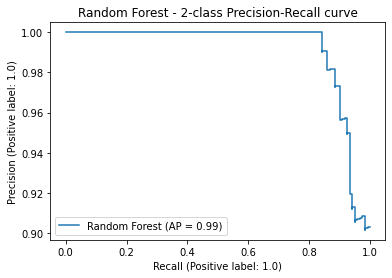

In [59]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    RFC_search, X_test, y_test, name="Random Forest"
)
_ = display.ax_.set_title("Random Forest - 2-class Precision-Recall curve")

In [60]:
from numpy import unique
from numpy import argmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier

In [61]:
# define the keras model

from sklearn.base import clone
 
def create_keras_classifier_model(n_classes):
    """Keras multinomial logistic regression creation model
 
    Args:
        n_classes(int): Number of classes to be classified
 
    Returns:
        Compiled keras model
 
    """
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=len(X.columns), activation='relu', kernel_initializer='normal'))
    model.add(Dense(n_classes, activation="softmax"))
    # Compile model
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model
 
estimator = KerasClassifier(build_fn=create_keras_classifier_model, n_classes=2)

In [62]:
estimator.fit(X_train, y_train)

# Classifier predictions
NN_pred = estimator.predict(X_test)

#Printing out results
NN_report = classification_report(y_test, NN_pred)
print(NN_report)
pre_optimization_precision.append(round(precision_score(y_true=y_test, y_pred=NN_pred),3))
pre_optimization_accuracy.append(round(accuracy_score(y_true=y_test, y_pred=NN_pred),3))

22/22 [==============================] - 1s 1ms/step - loss: 1.3615 - accuracy: 0.6667
              precision    recall  f1-score   support

         0.0       0.73      0.35      0.48        54
         1.0       0.77      0.94      0.84       121

    accuracy                           0.76       175
   macro avg       0.75      0.65      0.66       175
weighted avg       0.75      0.76      0.73       175



In [63]:
# Parameters to Tune
params = {'epochs': [100,125,150,175,200],
          'batch_size': [5,10,20,30,40,50]}

NN_search = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=-1, cv=5, scoring='accuracy')

NN_search.fit(X,y)

Epoch 1/200
18/18 [==============================] - 1s 2ms/step - loss: 1.3488 - accuracy: 0.6979
Epoch 2/200
18/18 [==============================] - 0s 1ms/step - loss: 0.7768 - accuracy: 0.7551
Epoch 3/200
18/18 [==============================] - 0s 942us/step - loss: 0.5584 - accuracy: 0.8158
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8341
Epoch 5/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.8513
Epoch 6/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3286 - accuracy: 0.8535
Epoch 7/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3197 - accuracy: 0.8616
Epoch 8/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3081 - accuracy: 0.8719
Epoch 9/200
18/18 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.8684
Epoch 10/200
18/18 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8707
Epoch 1

Epoch 83/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1868 - accuracy: 0.9245
Epoch 84/200
18/18 [==============================] - 0s 1ms/step - loss: 0.1830 - accuracy: 0.9279
Epoch 85/200
18/18 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9256
Epoch 86/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1816 - accuracy: 0.9268
Epoch 87/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9314
Epoch 88/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1786 - accuracy: 0.9336
Epoch 89/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9314
Epoch 90/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1749 - accuracy: 0.9348
Epoch 91/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9416
Epoch 92/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9359


18/18 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9462
Epoch 165/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1471 - accuracy: 0.9416
Epoch 166/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9451
Epoch 167/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9439
Epoch 168/200
18/18 [==============================] - 0s 2ms/step - loss: 0.2424 - accuracy: 0.9359
Epoch 169/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1599 - accuracy: 0.9371
Epoch 170/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1821 - accuracy: 0.9336
Epoch 171/200
18/18 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.9211
Epoch 172/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9405
Epoch 173/200
18/18 [==============================] - 0s 2ms/step - loss: 0.2442 - accuracy: 0.9222
Epoc

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001B427491100>,
             n_jobs=-1,
             param_grid={'batch_size': [5, 10, 20, 30, 40, 50],
                         'epochs': [100, 125, 150, 175, 200]},
             scoring='accuracy')

In [64]:
print("Best Accuracy: %f using %s" % (NN_search.best_score_, NN_search.best_params_))
print("Mean Test Score:", np.mean(NN_search.cv_results_['mean_test_score']))
print("Mean Std. Test Score:", np.mean(NN_search.cv_results_['std_test_score']))
print("\nBest Parameter Found:")
NN_search.best_params_

Best Accuracy: 0.883343 using {'batch_size': 50, 'epochs': 200}
Mean Test Score: 0.8712672140120415
Mean Std. Test Score: 0.020563809392045173

Best Parameter Found:


{'batch_size': 50, 'epochs': 200}

In [65]:
NN_search = NN_search.best_estimator_

NN_search.fit(X_train, y_train)

Epoch 1/200
14/14 [==============================] - 1s 2ms/step - loss: 2.4362 - accuracy: 0.6123
Epoch 2/200
14/14 [==============================] - 0s 2ms/step - loss: 0.8219 - accuracy: 0.7411
Epoch 3/200
14/14 [==============================] - 0s 2ms/step - loss: 0.5285 - accuracy: 0.7682
Epoch 4/200
14/14 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.8212
Epoch 5/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.8369
Epoch 6/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3584 - accuracy: 0.8484
Epoch 7/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3395 - accuracy: 0.8498
Epoch 8/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3267 - accuracy: 0.8612
Epoch 9/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3143 - accuracy: 0.8555
Epoch 10/200
14/14 [==============================] - 0s 1ms/step - loss: 0.3081 - accuracy: 0.8584
Epoch 11/

14/14 [==============================] - 0s 1ms/step - loss: 0.1662 - accuracy: 0.9385
Epoch 84/200
14/14 [==============================] - 0s 1ms/step - loss: 0.1646 - accuracy: 0.9442
Epoch 85/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9385
Epoch 86/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.9328
Epoch 87/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9385
Epoch 88/200
14/14 [==============================] - 0s 1ms/step - loss: 0.1626 - accuracy: 0.9385
Epoch 89/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1701 - accuracy: 0.9399
Epoch 90/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1664 - accuracy: 0.9399
Epoch 91/200
14/14 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9371
Epoch 92/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.9399
Epoch 93/200


14/14 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9371
Epoch 165/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.9371
Epoch 166/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9399
Epoch 167/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.9485
Epoch 168/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9514
Epoch 169/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9499
Epoch 170/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9514
Epoch 171/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9471
Epoch 172/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.9499
Epoch 173/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1356 - accuracy: 0.9514
Epoc

In [85]:
# Classifier predictions
NN_pred = NN_search.predict(X_test)

#Printing out results
NN_report = classification_report(y_test, NN_pred)
print(NN_report)
post_optimization_precision.append(precision_score(y_true=y_test, y_pred=NN_pred))
post_optimization_accuracy.append(accuracy_score(y_true=y_test, y_pred=NN_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81        54
         1.0       0.93      0.88      0.91       121

    accuracy                           0.87       175
   macro avg       0.85      0.87      0.86       175
weighted avg       0.88      0.87      0.88       175



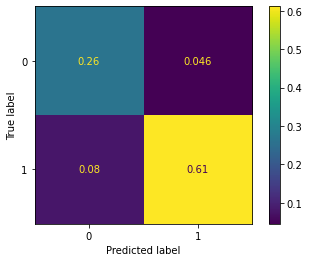

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
NN_cm = confusion_matrix(y_test, NN_pred, normalize='all')
NN_cmd = ConfusionMatrixDisplay(NN_cm)
NN_cmd.plot()

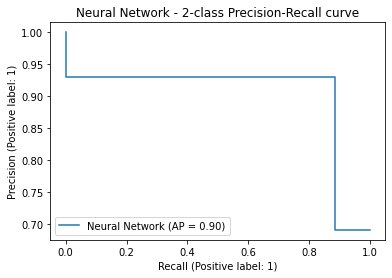

In [87]:
display = PrecisionRecallDisplay.from_predictions(y_test, NN_pred, name="Neural Network")
_ = display.ax_.set_title("Neural Network - 2-class Precision-Recall curve")

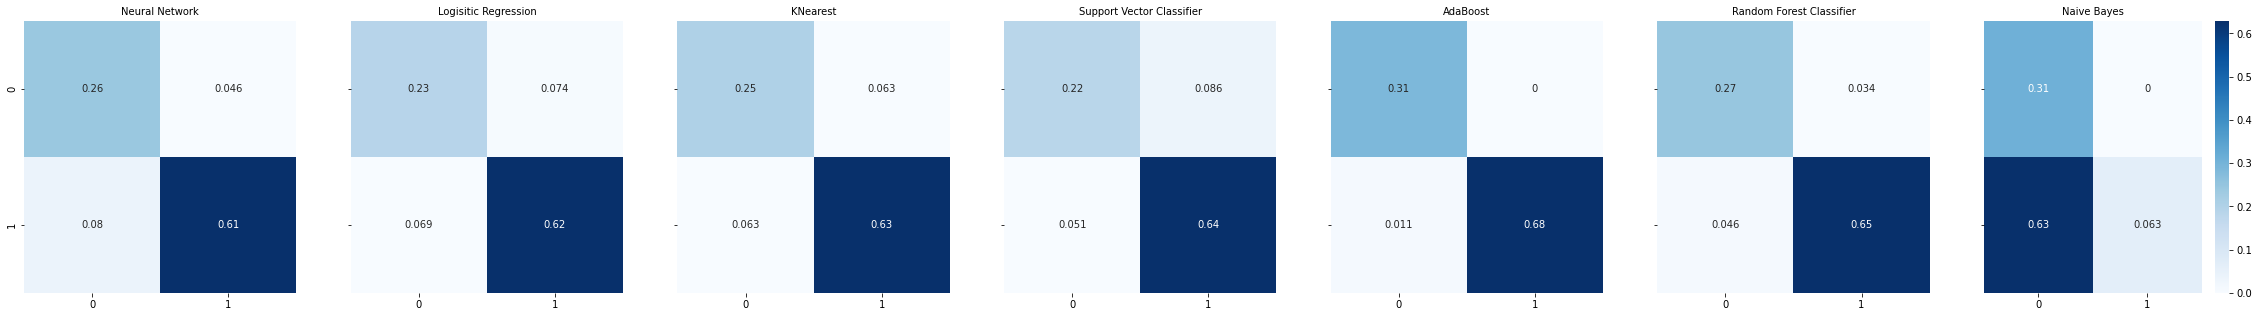

In [88]:
import seaborn as sns

classifiers = {
    "Neural Network": NN_cm,
    "Logisitic Regression": LogReg_cm,
    "KNearest": KNN_cm,
    "Support Vector Classifier": svm_cm,
    "AdaBoost": AdaBoost_cm,
    "Random Forest Classifier": RFC_cm,
    "Naive Bayes": NB_cm,
}

fig, axn = plt.subplots(1,7, sharex=True, sharey=True,figsize=(40,5))

for i, ax in enumerate(axn.flat):
    k = list(classifiers)[i]
    sns.heatmap(classifiers[k], ax=ax, cbar=i==6, annot=True, cmap='Blues')
    ax.set_title(k,fontsize=10)

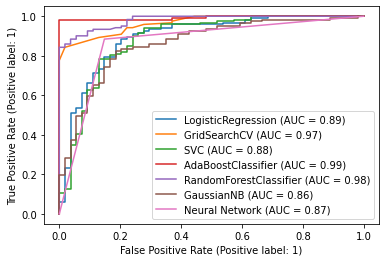

In [89]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve

classifiers_model = [
    LogReg_search,
    KNN_search,
    svm_search,
    AdaBoost_search,
    RFC_search,
    NB_search,
    NN_search
]

ax = plt.gca()
for i in classifiers_model:
    try:
        plot_roc_curve(i, X_test, y_test, ax=ax)
    except ValueError:
        RocCurveDisplay.from_predictions(y_pred=NN_pred, y_true=y_test, ax=ax, name='Neural Network')

#for name, model in classifiers_model.items():
#    try:
#        RocCurveDisplay.from_estimator(model, X_test, y_test)
#    except ValueError:
#        RocCurveDisplay.from_predictions(y_pred=NN_pred, y_true=y_test)

#plt.show()

In [71]:
X = ['AdaBoost','Naive Bayes','Logistic Regression','SVM','KN Neighbour','Random Forest','Neural Network']
metrices = pd.DataFrame(zip(X, pre_optimization_precision,post_optimization_precision,
                            pre_optimization_accuracy, post_optimization_accuracy),
                        columns=['Classifier','Precision - Bf','Precision - Af','Accuracy - Bf','Accuracy - Af'])

metrices = metrices.sort_values('Precision - Af',ascending=False)
metrices

,Classifier,Precision - Bf,Precision - Af,Accuracy - Bf,Accuracy - Af
0,AdaBoost,0.991667,1.000000,0.982857,0.989000
1,Naive Bayes,0.984000,1.000000,0.646000,0.371429
5,Random Forest,0.958000,0.950000,0.931000,0.920000
6,Neural Network,0.765000,0.930435,0.760000,0.874286
4,KN Neighbour,0.855000,0.909091,0.811000,0.874286
2,Logistic Regression,0.891667,0.893000,0.845714,0.857000
3,SVM,0.767742,0.882000,0.782857,0.863000


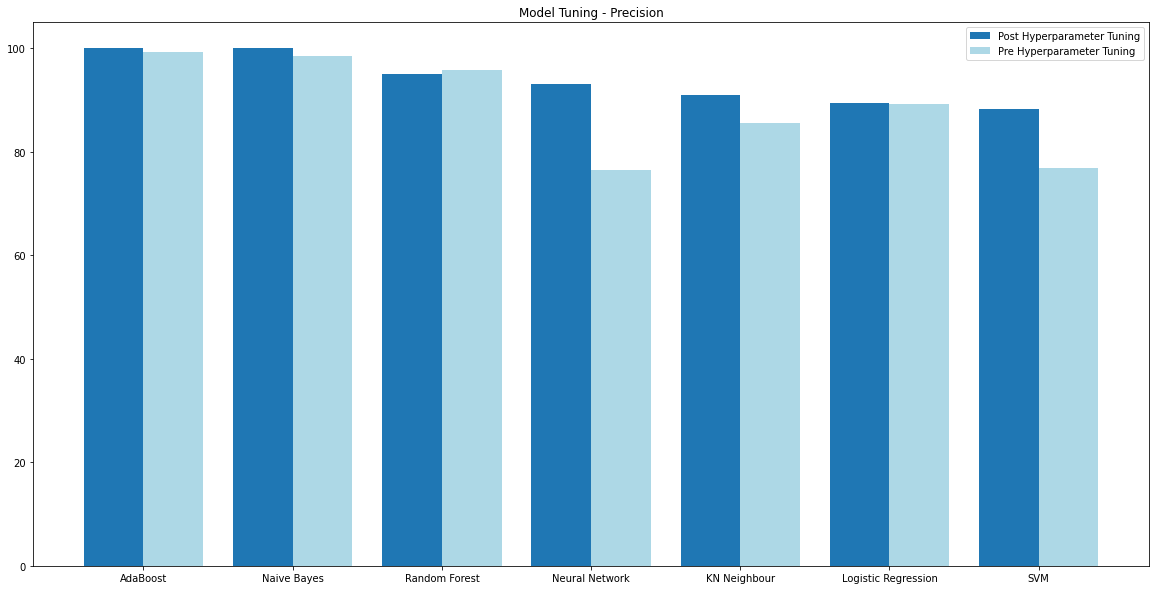

In [72]:
X_axis = np.arange(len(metrices))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, metrices['Precision - Af'] * 100, 0.4, label = 'Post Hyperparameter Tuning')
plt.bar(X_axis + 0.2, metrices['Precision - Bf'] * 100, 0.4, label = 'Pre Hyperparameter Tuning',
        color='lightblue')

plt.xticks(X_axis, metrices['Classifier'])
plt.title("Model Tuning - Precision")
plt.legend()
plt.show()

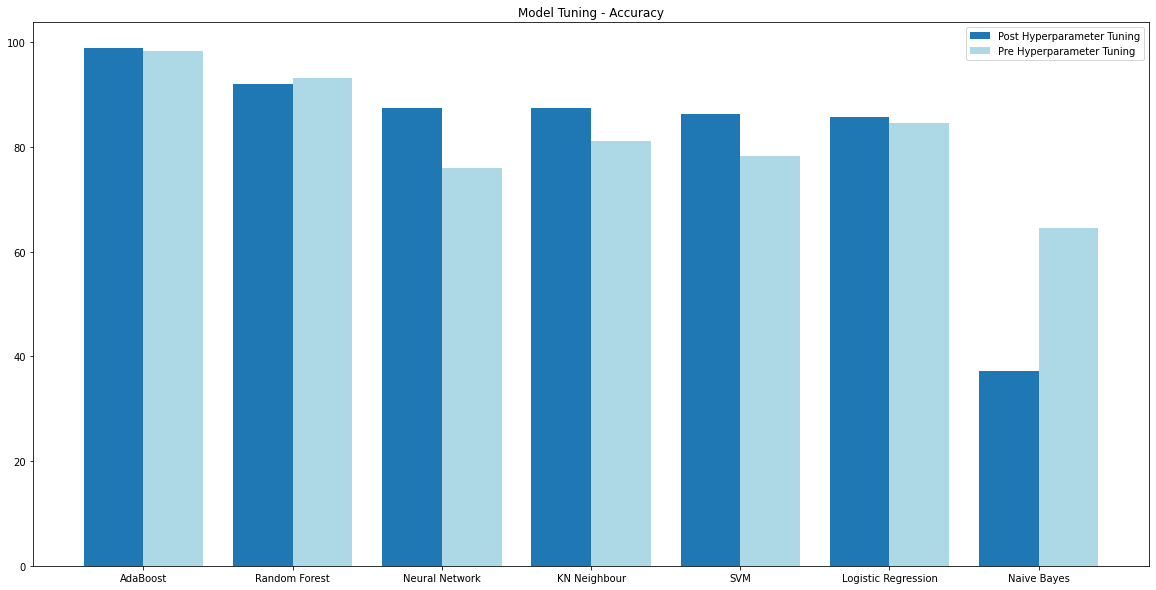

In [73]:
metrices = metrices.sort_values('Accuracy - Af',ascending=False)
  
X_axis = np.arange(len(metrices))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, metrices['Accuracy - Af'] * 100, 0.4, label = 'Post Hyperparameter Tuning')
plt.bar(X_axis + 0.2, metrices['Accuracy - Bf'] * 100, 0.4, label = 'Pre Hyperparameter Tuning',color='lightblue')
  
plt.xticks(X_axis, metrices['Classifier'])
plt.title("Model Tuning - Accuracy")
plt.legend()
plt.show()

In [74]:
latest_data = fundamentals[fundamentals.dates == '2021-03-01']

features = latest_data.drop(columns=['stocks','dates','EntValue','Label','Score'])
features

,NPS,DivPS,ROCE,NPMargin,Price2Book,RetentionRatios,EarningYield,EntValue_Prcnt_change,Price2Book_Prcnt_change
0,17.71,6.0,15.93,7.14,25.68,0.00,0.01,102.125028,56.585366
10,18.36,1.0,27.49,20.00,5.02,94.55,0.04,108.550580,107.438017
20,11.66,2.5,20.01,16.81,2.23,97.43,0.06,60.897033,42.948718
30,2.88,10.0,8.90,1.93,6.31,-108.18,0.00,93.311398,102.893891
40,185.07,37.0,15.32,12.36,4.49,92.98,0.03,85.745182,83.265306
...,...,...,...,...,...,...,...,...,...
943,16.26,2.0,27.11,13.14,19.77,95.38,0.01,130.236669,88.465205
953,-1.07,0.6,-0.91,-2.05,4.77,0.00,-0.01,151.719961,174.137931
963,9.49,5.0,9.79,44.04,6.60,0.00,0.01,134.162324,154.826255
973,140.95,30.0,24.67,23.34,4.35,80.13,0.05,15.988166,-1.805869


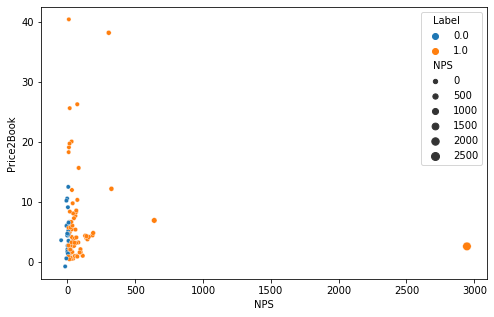

In [75]:
AdaBoost_pred = AdaBoost_search.predict(features)

features['Label']=AdaBoost_pred

latest_data['AdaBoost_Label'] = AdaBoost_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

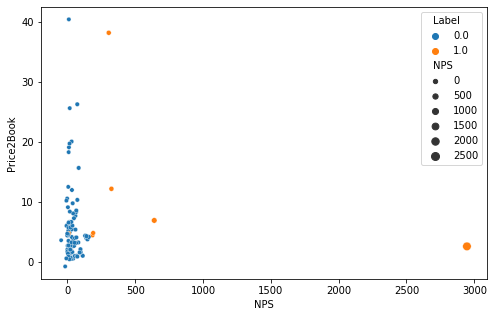

In [76]:
features = features.drop(columns=['Label'],axis=1)
NB_pred = NB_search.predict(features)

features['Label']=NB_pred

latest_data['NB_Label'] = NB_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

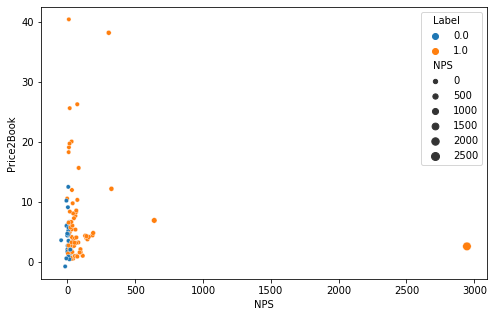

In [77]:
features = features.drop(columns=['Label'],axis=1)
LogReg_pred = LogReg_search.predict(features)

features['Label']=LogReg_pred

latest_data['LogReg_Label'] = LogReg_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

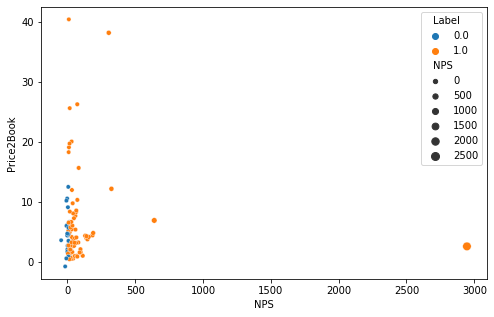

In [78]:
features = features.drop(columns=['Label'],axis=1)
svm_pred = svm_search.predict(features)

features['Label']=svm_pred

latest_data['SVM_Label'] = svm_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

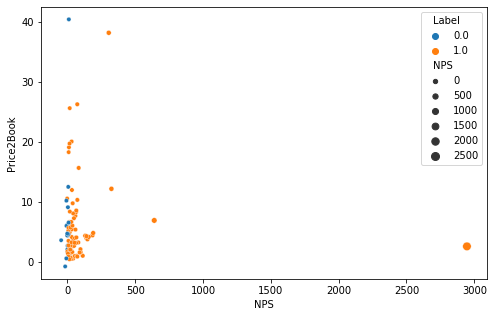

In [79]:
features = features.drop(columns=['Label'],axis=1)
KNN_pred = KNN_search.predict(features)

features['Label']=KNN_pred

latest_data['KNN_Label'] = KNN_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

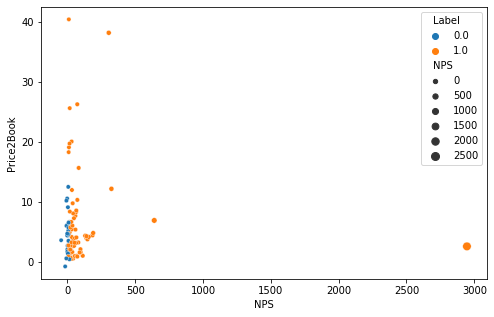

In [80]:
features = features.drop(columns=['Label'],axis=1)
RFC_pred = RFC_search.predict(features)

features['Label']=RFC_pred

latest_data['RFC_Label'] = RFC_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

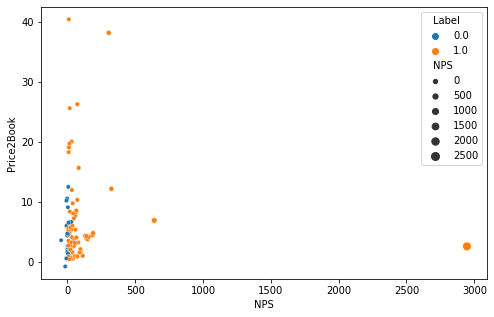

In [81]:
features = features.drop(columns=['Label'],axis=1)
NN_pred = NN_search.predict(features)

features['Label']=NN_pred

latest_data['NN_Label'] = NN_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=features.NPS,y=features.Price2Book,hue=features.Label,
                data=features,
               size=features.NPS)
plt.show()

In [97]:
## Did not used the predicions from Naive Bayes as it is the worst performing Model
top_stocks_for_2022 = latest_data[(latest_data.RFC_Label == 1.0)]
top_stocks_for_2022['stocks']

0            ZEEL
10          WIPRO
20         VOLTAS
40     ULTRACEMCO
61       TVSMOTOR
          ...    
923        ASTRAL
933    ASIANPAINT
943      ASHOKLEY
973    ABBOTINDIA
993      AARTIIND
Name: stocks, Length: 73, dtype: object

In [82]:
## Did not used the predicions from Naive Bayes as it is the worst performing Model
top_stocks_for_2022 = latest_data[(latest_data.AdaBoost_Label == 1.0) & (latest_data.LogReg_Label == 1.0) & (latest_data.SVM_Label == 1.0) & (latest_data.KNN_Label == 1.0) & (latest_data.RFC_Label == 1.0) & (latest_data.NN_Label == 1.0)]
top_stocks_for_2022.stocks

0            ZEEL
10          WIPRO
20         VOLTAS
40     ULTRACEMCO
61       TVSMOTOR
          ...    
923        ASTRAL
933    ASIANPAINT
943      ASHOKLEY
973    ABBOTINDIA
993      AARTIIND
Name: stocks, Length: 67, dtype: object

In [83]:
# Stock list extract from Groww
import nsepy
import datetime

stock_list = top_stocks_for_2022.stocks.to_list()
stock_data = pd.DataFrame()

for sym in stock_list:
#     print(sym)
    d = nsepy.get_history(symbol=sym,start=datetime.date(2021,12,31),end=datetime.date(2022,4,30))
    stock_data = pd.concat([stock_data, d])
stock_data.sort_index(ascending=False)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-04-29,AARTIIND,EQ,885.40,889.00,901.70,882.00,885.90,887.95,891.72,402693,3.590876e+13,16521,163880,0.4070
2022-04-29,IRCTC,EQ,757.40,759.95,766.65,745.00,747.00,745.95,753.84,1428538,1.076884e+14,47855,522015,0.3654
2022-04-29,RELIANCE,EQ,2819.85,2856.15,2856.15,2777.30,2799.70,2790.25,2817.63,8406156,2.368543e+15,231044,4308908,0.5126
2022-04-29,COALINDIA,EQ,190.25,192.50,193.00,181.90,182.85,182.85,186.05,21654415,4.028810e+14,99811,9302778,0.4296
2022-04-29,ITC,EQ,261.10,263.00,263.00,258.50,259.50,259.55,260.72,20419904,5.323941e+14,110925,13489071,0.6606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,RAMCOCEM,EQ,984.70,988.00,1023.00,982.10,1007.00,1004.10,1009.73,365120,3.686716e+13,28070,126719,0.3471
2021-12-31,CIPLA,EQ,952.75,955.00,957.25,942.00,944.05,944.10,947.38,2039044,1.931756e+14,53558,1030648,0.5055
2021-12-31,AARTIIND,EQ,983.10,982.00,1007.70,980.00,1001.90,1004.60,1002.55,546275,5.476672e+13,21859,244970,0.4484


In [136]:
increase_decrease = pd.DataFrame()
stocks_list = stock_data['Symbol'].unique
LastYear = []
Now = []
for symbol in stock_list:
    LastYear.append(stock_data[(stock_data.Symbol == symbol) & (stock_data.index == datetime.date(2022,3,31))]['Close'].to_list()[0])
    Now.append(stock_data[(stock_data.Symbol == symbol) & (stock_data.index == datetime.date(2022,4,5))]['Close'].to_list()[0])

increase_decrease['Stock'] = stock_list
increase_decrease['LastYear'] = LastYear
increase_decrease['Now'] = Now
increase_decrease['Percent_change'] = ((increase_decrease.Now - increase_decrease.LastYear) / increase_decrease.LastYear) * 100
df = increase_decrease.sort_values(by=['Percent_change'],ascending=False).drop_duplicates()

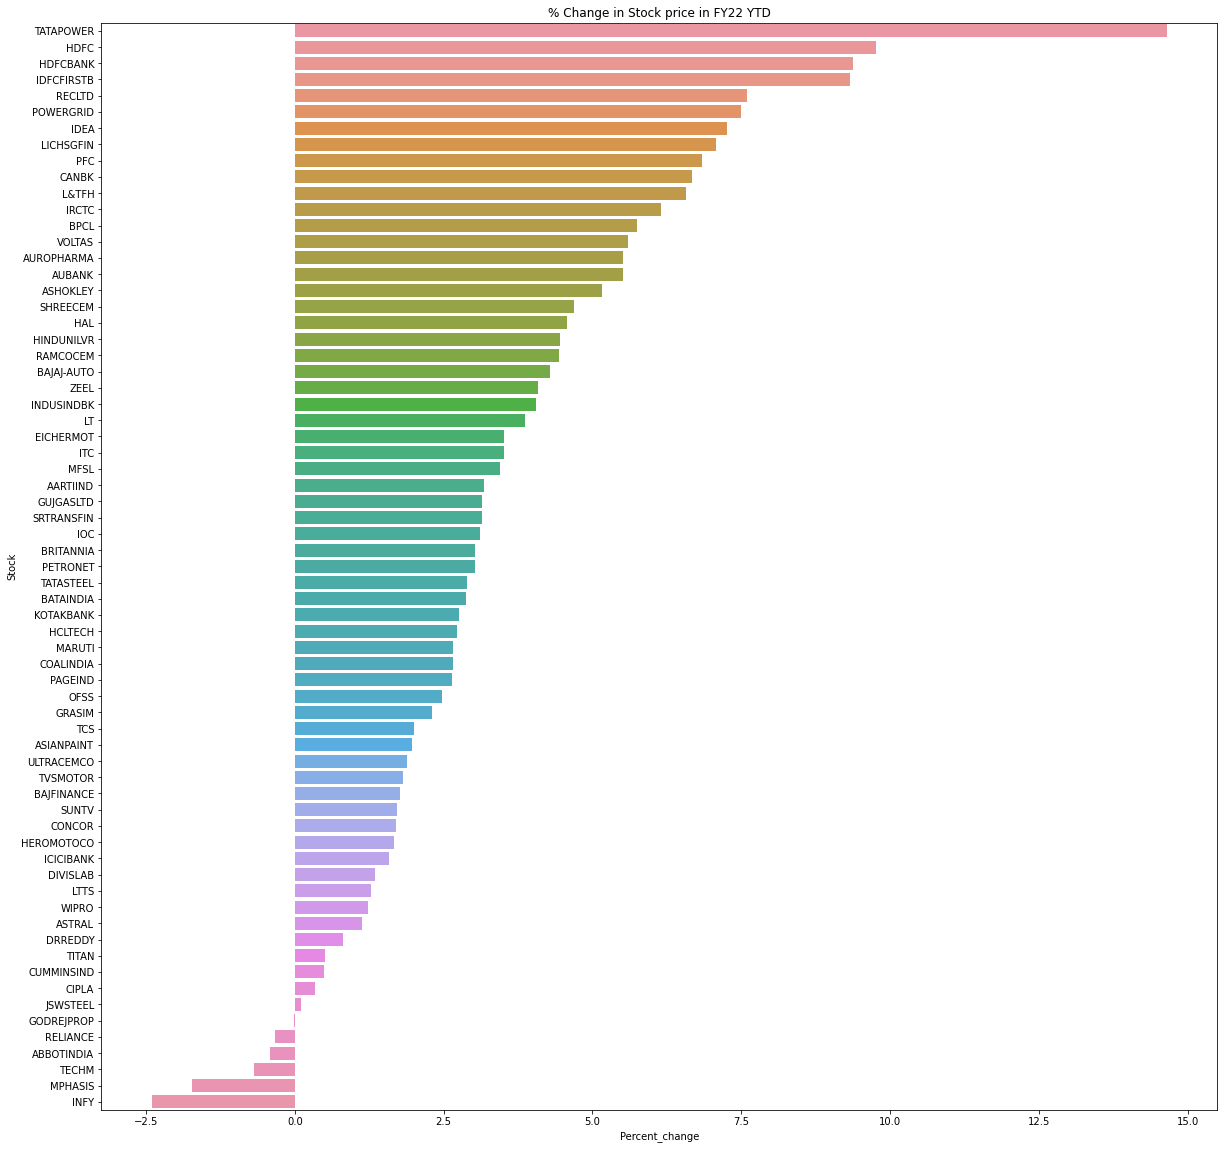

In [139]:
plt.figure(figsize=(20,20))
plt.title('% Change in Stock price in FY22 YTD')
sns.barplot(y='Stock', x='Percent_change', data=df)
plt.show()

In [142]:
from scipy.stats import describe, normaltest

res = describe(df.Percent_change)

print(res)

normaltest(df.Percent_change)

DescribeResult(nobs=67, minmax=(-2.3992448278574616, 14.644877435575115), mean=3.4551683413433443, variance=8.763824468337047, skewness=0.9871091286502341, kurtosis=1.8993809908133592)


NormaltestResult(statistic=16.093106268038657, pvalue=0.00032020372182865276)